In [1]:
import chronos as cr

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


* remove scattered light using `RegressionCorrector`
* remove systematics using `PLDCorrector`

In [2]:
t = cr.Target(toiid=837)

Available sectors: [10, 11]
sector 10 is used.



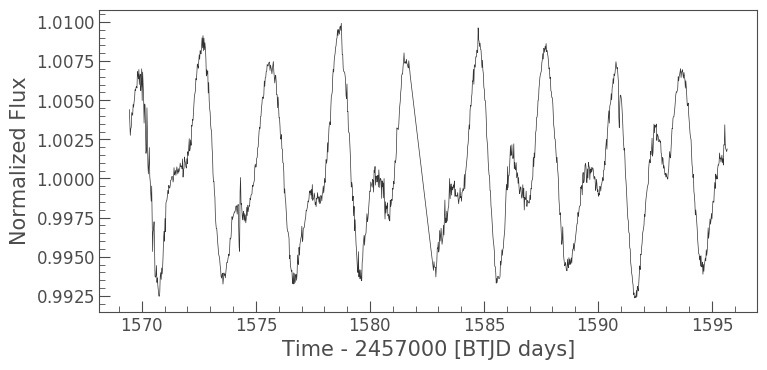

In [3]:
lc1 = t.make_custom_ffi_lc(with_offset=True)
lc1.plot()

Available sectors: [10, 11]
sector 10 is used.



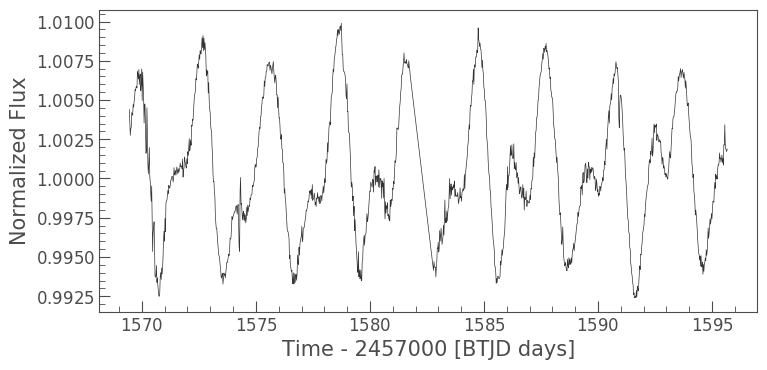

In [4]:
lc2 = t.make_custom_ffi_lc(with_offset=False)
lc2.plot()

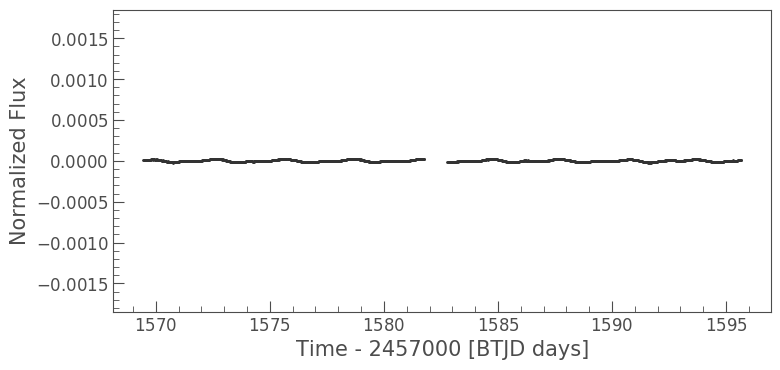

In [5]:
(lc1-lc2).scatter()

## Scattered Light removal

In [6]:
import lightkurve as lk

In [7]:
# tpf = lk.search_tesscut(t.target_coord, sector=t.get_all_sectors()[0]).download(cutout_size=(50, 50))
tpf = t.tesscut_tpf
tpf.shape

(1205, 50, 50)

In [8]:
aper = tpf.create_threshold_mask(threshold=3)

In [9]:
raw_lc = tpf.to_lightcurve(aperture_mask=aper)

In [20]:
idx = eig_vals.argsort()
Y = X[:,idx] @ eig_vecs[idx] 

In [21]:
Y.shape

(1205, 2484)

In [19]:
eig_vals.shape, eig_vecs.shape

((2484,), (2484, 2484))

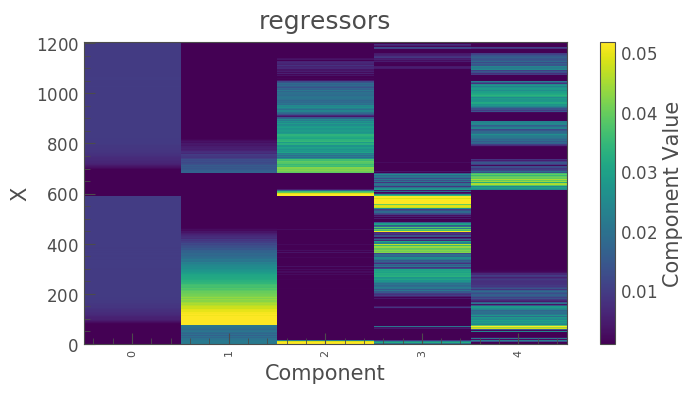

In [32]:
regressors = tpf.flux[:, ~aper]
pca_nterms = 5
dm = lk.DesignMatrix(regressors, name='regressors').pca(nterms=pca_nterms)
dm.plot()

In [33]:
dm.values.shape

(1205, 5)

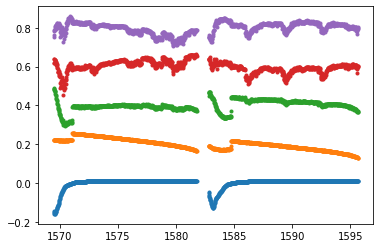

In [34]:
import numpy as np
import matplotlib.pyplot as pl
pl.plot(tpf.time, dm.values + np.arange(5)*0.2, '.');

In [22]:
X = tpf.flux[:, ~aper]
Cov = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(Cov)
cev = np.cumsum(eig_vals) / np.sum(eig_vals)

Text(0, 0.5, 'CEV')

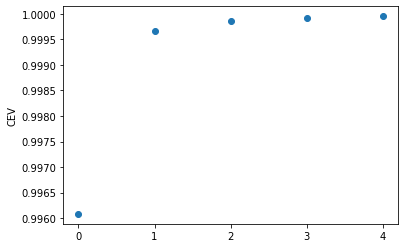

In [38]:
#first 5 pca terms is enough to explain ~100% of the variance
pl.plot(cev[:pca_nterms], 'o')
pl.xticks(range(pca_nterms));
pl.ylabel('CEV')

In [38]:
dm=dm.append_constant()

In [39]:
corrector = lk.RegressionCorrector(raw_lc)
corrected_lc = corrector.correct(dm)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8077c29a10>,
      dtype=object)

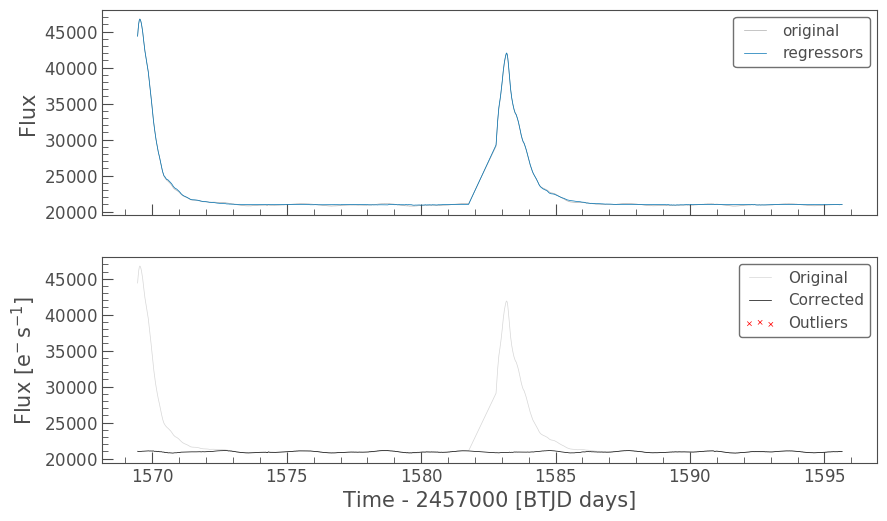

In [40]:
corrector.diagnose()

with outlier rejection

In [41]:
clean_lc, outlier_mask = tpf.to_lightcurve(
            aperture_mask=aper
        ).remove_outliers(return_mask=True)

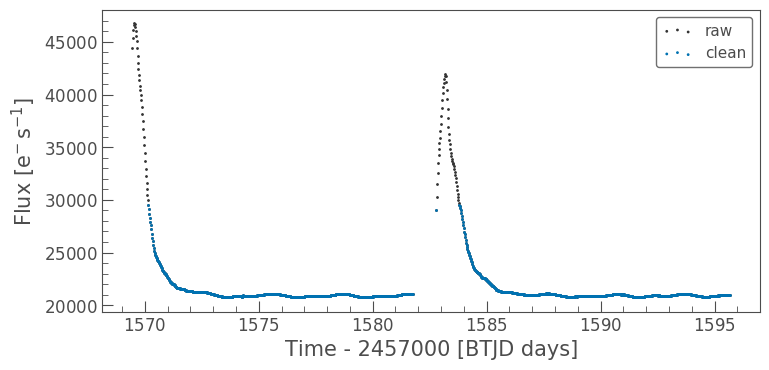

In [42]:
ax = raw_lc.scatter(label='raw')
clean_lc.scatter(ax=ax, label='clean')

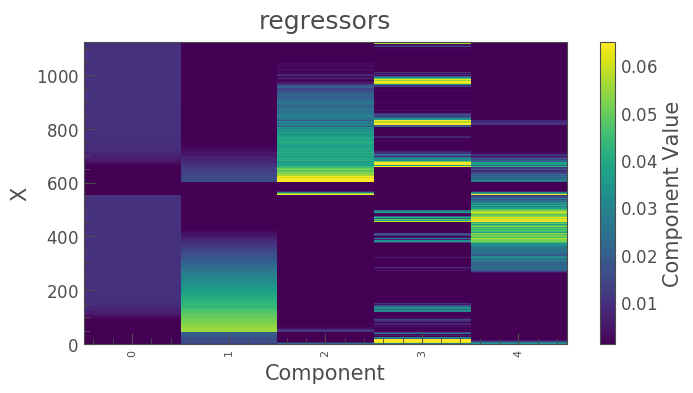

In [43]:
regressors = tpf.flux[:, ~aper][~outlier_mask]
dm = lk.DesignMatrix(regressors, name='regressors').pca(5)
dm.plot()

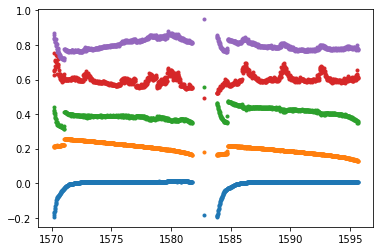

In [44]:
import numpy as np
import matplotlib.pyplot as pl
pl.plot(tpf.time[~outlier_mask], dm.values + np.arange(5)*0.2, '.');

In [45]:
corrector = lk.RegressionCorrector(clean_lc)
corrected_lc = corrector.correct(dm)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8076e23c50>,
      dtype=object)

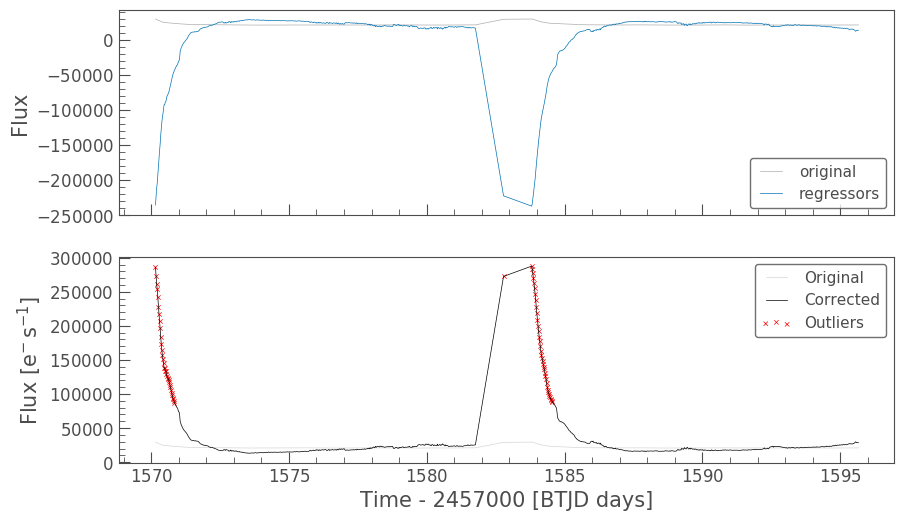

In [46]:
corrector.diagnose()

## PLD

In [47]:
lc = t.make_custom_ffi_lc(with_offset=True)

Available sectors: [10, 11]
sector 10 is used.



In [68]:
aper_mask = tpf.cutout(size=5).create_threshold_mask()
pld = lk.PLDCorrector(tpf.cutout(size=5))
corr_lc = (
    pld.correct(
        aperture_mask=aper_mask,
        use_gp=True,
        # True means cadence is considered in the noise model
        #cadence_mask=~cadence_mask_tpf if cadence_mask_tpf.sum()>0 else None,
        # True means the pixel is chosen when selecting the PLD basis vectors
        #pld_aperture_mask=mask,
        # gp_timescale=30, n_pca_terms=10, pld_order=2,
    )
    .remove_nans()
    .remove_outliers()
    .normalize()
)

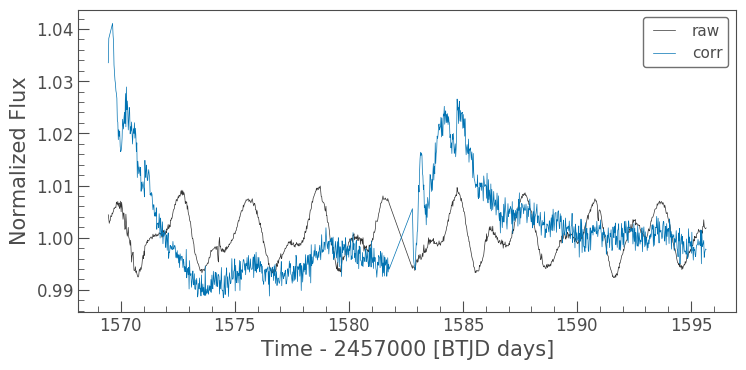

In [71]:
ax = lc.plot(label='raw')
corr_lc.plot(ax=ax, label='corr')